<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Reduce tail latencies for ANN queries by tuning ANN-parameters for your Vespa application

<div class="alert alert-info">
    You probably want to be somewhat familiar with Vespa and ANN search before going through this example.<br>Recommended background reading: 
    <ul>
        <li><a href="https://docs.vespa.ai/en/nearest-neighbor-search-guide.html">Vespa nearest neighbor search - a practical guide</a></li>
        <li><a href="https://blog.vespa.ai/approximate-nearest-neighbor-search-in-vespa-part-1/">ANN Search in Vespa</a></li>
        <li><a href="https://blog.vespa.ai/constrained-approximate-nearest-neighbor-search/">Query Time Constrained Approximate Nearest Neighbor Search</a></li>
        <li><a href="https://blog.vespa.ai/additions-to-hnsw/">Additions to HNSW in Vespa: ACORN-1 and Adaptive Beam Search</a></li>
        <li><a href="https://blog.vespa.ai/tweaking-ann-parameters/">A Short Guide to Tweaking Vespa's ANN Parameters</a></li>
    </ul>
</div>    

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vespa-engine/pyvespa/blob/master/docs/sphinx/source/ann-parameter-tuning-vespa-cloud.ipynb)

Approximate Nearest Neighbor (ANN) search is a powerful way to make vector search scalable and efficient. In Vespa, this is implemented by building HNSW graphs for embedding fields.

## Why different strategies are needed

For a search that uses _only_ vector similarity for retrieval, this works very well for all cases, as you can just query the HNSW index and get (enough) relevant results back very fast.

However, most Vespa applications are more complex, and implement some sort of hybrid retrieval strategy, often combining vector similarity with filtering on metadata fields and/or lexical matching (weakAnd).

In this case, it is not obvious whether applying the filter first and doing an exact search will be more efficient than doing HNSW (in different variations, as we will get back to). 

The _hit-ratio_ of the filter for a given query will determine what is the most efficient strategy for the given query. 

The part that complicates this further is that the tipping point for which a strategy should be used depends on your corpus, and is thus not uniform across Vespa applications.

Therefore, the parameters must be tuned for each application (and maybe retuned, if your data distribution changes significantly).

This notebook will demonstrate how this tuning can be done with the recent addition of the `VespaNNParameterOptimizer` class. 

Hopefully, by stepping through this notebook, you will have learned how you can apply the same steps to tune _your_ Vespa application (ANN configuration parameters) to get faster search responses while still maintaining acceptable recall. 

## A short note on `recall`

It is worth noting that our definition of `recall` in the context of tuning NN-parameters differs slightly from the `recall` definition used in eg. `VespaMatchEvaluator` (see https://vespa-engine.github.io/pyvespa/evaluating-vespa-application-cloud.html).

When optimizing NN-parameters, the recall will be the fraction of top K (targetHits) documents scored by exact distance that are also retrieved by the given strategy. 

This approach does not need a set of `relevant_docs`,in contrast to the `VespaMatchEvaluator`, which calculates the recall as fraction of relevant documents that are retrieved.

The good news is that a set of representative queries is all we need to tune these parameters to find the values that ensures a fast response time _and_ maintains acceptable recall across your provided queries. 

## The different strategies

With the recent addition of ACORN-1 and Adaptive Beam Search to Vespa's ANN implementation, Vespa now switches between one of the following three strategies:

1. HNSW Search with Pre-Filtering when the percentage of filtered-out documents is low,
2. HNSW Search with Pre-Filtering: Filter First/ACORN-1 when the percentage of filtered-out documents is high,
3. Exact Nearest-Neighbor Search when the percentage of filtered-out documents approaches 100%.

_When_ to switch between these three strategies is determined by a combination of a per-query internally calculated `hit-ratio` and the parameters below:

- `filter-first-exploration`: Value (in the range [0.0, 1.0]) specifying how aggressively the filter-first heuristic explores the graph when searching the HNSW graph for approximate neighbors with filtering. A higher value means that the graph is explored more aggressively and improves the recall at the cost of the response time. (Default value is 0.3.)
- `filter-first-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if the filter is checked before computing a distance (filter-first heuristic) while searching the HNSW graph for approximate neighbors with filtering. This improves the response time at low hit ratios but causes a dip in recall. The heuristic is used when the estimated filter hit ratio of the query is less than this threshold. The default value is 0.3.
- `approximate-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if a query with an approximate nearestNeighbor operator combined with filters is evaluated by searching the HNSW graph for approximate neighbors with filtering, or performing an exact nearest neighbor search with pre-filtering. The fallback to exact search is chosen when the estimated filter hit ratio of the query is less than this threshold. The default value is 0.02.
- `post-filter-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if a query with an approximate nearestNeighbor operator combined with filters is evaluated using post-filtering instead of the default filtering. Post-filtering is chosen when the estimated filter hit ratio of the query is larger than this threshold. The default value is 1.0, which disables post-filtering. 

These parameters can be configured per rank profile or provided as a query parameter, which is passed with the query, and may have a big effect on query performance of queries that combines ANN search with filters.

In this notebook, we will show how to tune these parameters to ensure low response time, without losing much recall compared to exact search.

As a teaser, this is the report we will produce:
 
(Keep reading if you want to understand more)

<img alt="#ANN Optimization report" src="../_static/ann_opt_report.png" style="margin-bottom: 25px;">

<div class="alert alert-info">
    Refer to <a href="https://vespa-engine.github.io/pyvespa/troubleshooting.html">troubleshooting</a>
    for any problem when running this guide.
</div>


**Pre-requisite**: Create a tenant at [cloud.vespa.ai](https://cloud.vespa.ai/), save the tenant name.

Now, let us get started with the practical part. 

## The dataset

The dataset we will use for this notebook is a subset of the [GIST1M-dataset](http://corpus-texmex.irisa.fr/) commonly used for ANN benchmarks.

We have also enriched each document with a `filter`-field of type `array<int>`, that is added to each document, which allows us to construct queries with a predictable hit ratio.

Here is an example document:

```json
{
  "put": "id:test:test::499",
  "fields": {
    "id": 499,
    "filter": [1,10,50,90,95,99],
    "vec_m16": { "values": [0.01345, .., 0.30322] } // 960 float values 
  }
}
```

99% of the documents include the value 1 in the filter field, 90% of the documents include the value 10 in the fitler field and so on.

## Configuring your application

In [1]:
# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "vespa-team"
# Replace with your application name (does not need to exist yet)
application = "anntuning"

## Downloading the dataset

In [ ]:
import os
import pathlib
import requests
import matplotlib.pyplot as plt
from vespa.io import VespaResponse

data_base_url = (
    "https://data.vespa-cloud.com/tests/performance/nearest-neighbor/gist-data/"
)

# We use a smaller dataset if the SCALE_DOWN flag is set to True
SCALE_DOWN = True
docs_url = (
    data_base_url + "docs.1k.json" if SCALE_DOWN else data_base_url + "docs.300k.json"
)
query_url = (
    data_base_url + "query_vectors.10.txt"
    if SCALE_DOWN
    else data_base_url + "query_vectors.100.txt"
)
NUMBER_OF_HITS = 10 if SCALE_DOWN else 100

In [3]:
def download_file(url: str, dest_folder: str):
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    if os.path.exists(local_filename):
        print(f"File {local_filename} already exists, skipping download.")
        return local_filename
    print(f"Downloading {url} to {local_filename}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename


data_path = "ann_test/"
pathlib.Path(data_path).mkdir(parents=True, exist_ok=True)

docs_path = download_file(docs_url, data_path)
query_path = download_file(query_url, data_path)

File ann_test/docs.300k.json already exists, skipping download.
File ann_test/query_vectors.100.txt already exists, skipping download.


## Defining the Vespa application

In [ ]:
from vespa.package import (
    ApplicationPackage,
    Schema,
    Document,
    Field,
    RankProfile,
    HNSW,
    DocumentSummary,
    Summary,
)
from vespa.configuration.query_profiles import query_profile, query_profile_type, field


# Define the document with fields
doc = Document(
    fields=[
        Field(
            name="id",
            type="int",
            indexing=["attribute", "summary"],
        ),
        Field(
            name="filter",
            type="array<int>",  # This is our filter field
            indexing=["attribute", "summary"],
            attribute=["fast-search"],
        ),
        Field(
            name="vec_m16",
            type="tensor<float>(x[960])",  # The vector field that we will do ANN search on
            indexing=["attribute", "index", "summary"],
            ann=HNSW(
                distance_metric="euclidean",  # specific to this dataset
                max_links_per_node=16,  #
                neighbors_to_explore_at_insert=500,  # Specifies how many neighbors to explore when inserting a vector in the HNSW graph. The default value in Vespa is 200. This parameter is called efConstruction in the HNSW paper.
            ),
        ),
    ]
)

# Define the rank profile with HNSW tuning parameters
rank_profile = RankProfile(
    name="default",
    inputs=[
        ("query(q_vec)", "tensor<float>(x[960])"),
    ],
    first_phase="closeness(label,nns)",
    # We will tune some of these by overriding them as query parameters later
    rank_properties=[
        ("approximate-threshold", 0.02),
        ("filter-first-threshold", 0.3),
        ("filter-first-exploration", 0.3),
        ("exploration-slack", 0.0),
    ],
)

# Define a minimal document summary to avoid unnecessary data transfer
minimal_summary = DocumentSummary(name="minimal", summary_fields=[Summary(name="id")])

# Create the schema
schema = Schema(
    name=application,
    document=doc,
    rank_profiles=[rank_profile],
    document_summaries=[minimal_summary],
)

# We also define a query profile type for the default query profile to enforce the type of the input tensor
# See https://docs.vespa.ai/en/query-profiles.html#query-profile-types
qp = query_profile(
    id="default",
    type="root",
)

qpt = query_profile_type(
    field(
        name="ranking.features.query(q_vec)",
        type="tensor<float>(x[960])",
    ),
    id="root",
    inherits="native",
)

# Create the application package
app_package = ApplicationPackage(
    name=application, schema=[schema], query_profile_config=[qp, qpt]
)

It is often useful to dump the application package to files for inspection before deploying. 

In [5]:
app_package.to_files("ann_test")

In [45]:
from vespa.deployment import VespaCloud
from vespa.application import Vespa


# Key is only used for CI/CD. Can be removed if logging in interactively
key = os.getenv("VESPA_TEAM_API_KEY", None)
if key is not None:
    key = key.replace(r"\n", "\n")  # To parse key correctly


vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=application,
    key_content=key,  # Key is only used for CI/CD. Can be removed if logging in interactively
    application_package=app_package,
)

Setting application...
Running: vespa config set application vespa-team.anntuning.default
Setting target cloud...
Running: vespa config set target cloud

Api-key found for control plane access. Using api-key.


Now deploy the app to Vespa Cloud dev zone.

The first deployment typically takes a few minutes until the endpoint is up. (Applications that for example refer to large onnx-models may take a bit longer.)

In [47]:
app: Vespa = vespa_cloud.deploy()

Deployment started in run 13 of dev-aws-us-east-1c for vespa-team.anntuning. This may take a few minutes the first time.
INFO    [08:14:31]  Deploying platform version 8.607.21 and application dev build 11 for dev-aws-us-east-1c of default ...
INFO    [08:14:31]  Using CA signed certificate version 1
INFO    [08:14:31]  Using 1 nodes in container cluster 'anntuning_container'
INFO    [08:14:34]  Session 388239 for tenant 'vespa-team' prepared and activated.
INFO    [08:14:34]  ######## Details for all nodes ########
INFO    [08:14:34]  h125495b.dev.us-east-1c.aws.vespa-cloud.net: expected to be UP
INFO    [08:14:34]  --- platform vespa/cloud-tenant-rhel8:8.607.21
INFO    [08:14:34]  --- storagenode on port 19102 has config generation 388235, wanted is 388239
INFO    [08:14:34]  --- searchnode on port 19107 has config generation 388239, wanted is 388239
INFO    [08:14:34]  --- distributor on port 19111 has config generation 388235, wanted is 388239
INFO    [08:14:34]  --- metricsproxy-c

## Feeding the documents

In [9]:
# Load and feed documents
import json

with open(docs_path, "r") as f:
    docs = json.load(f)

In [10]:
def docs_gen(docs):
    for doc in docs:
        yield {
            "id": str(doc["fields"]["id"]),
            "fields": doc["fields"],
        }

In [11]:
def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print(
            "Id "
            + id
            + " + failed : "
            + response.json["id"]
            + "Status code: "
            + str(response.status_code)
        )


app.feed_iterable(docs_gen(docs), max_queue_size=100, callback=callback)

## Constructing queries

As we noted in the introduction, a set of representative queries is all that is needed for tuning ANN parameters. 

When we will compare recall, we will compare against the recall of the exact nearest neighbor search. 

We will use the [Querybuilder API](../query.html#using-the-querybuilder-dsl-api) to construct our queries.

In [12]:
import vespa.querybuilder as qb


def vector_to_query(vec_str: str, filter_value: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_(application)
            .where(
                qb.nearestNeighbor(
                    "vec_m16",
                    "q_vec",
                    annotations={
                        "targetHits": NUMBER_OF_HITS,
                        "approximate": True,
                        "label": "nns",
                    },
                )
                & (qb.QueryField("filter") == filter_value),
            )
        ),
        "hits": 10,
        "presentation.summary": "minimal",
        "timeout": "20s",
        "ranking.features.query(q_vec)": vec_str.strip(),
    }

In [13]:
with open(query_path, "r") as f:
    query_vectors = f.readlines()

# Filter values
filter_percentage = [1, 10, 50, 90, 95, 99]

# We will construct queries for each combination of query vector and filter value
queries = []
# We will also construct a single query per filter value for hit ratio evaluation
# The vector does not affect the hit ratio, so it is overkill to run a query for each vector
# just to determine the hit ratio
hitratio_queries = []  # will only have one query per filter value, choosing the last vector arbitrarily
for filter_value in filter_percentage:
    for vec in query_vectors:
        queries.append(vector_to_query(vec, filter_value))
    hitratio_queries.append(queries[-1])
print(len(queries), len(hitratio_queries))

600 6


Let us now run a test query against our Vespa app.

In [21]:
resp = app.query(queries[0])
resp.json

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 100},
  'coverage': {'coverage': 100,
   'documents': 300000,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'index:anntuning_content/0/546939e42a88c72c83bda0f7',
    'relevance': 0.5514919500458465,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 81360}},
   {'id': 'index:anntuning_content/0/9e6b6ea9df591d1672385a96',
    'relevance': 0.5493186760384602,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 284987}},
   {'id': 'index:anntuning_content/0/33ae6c85ba2829b2be268cd6',
    'relevance': 0.548701224770975,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 238816}},
   {'id': 'index:anntuning_content/0/355d6a2adcb93b4614536016',
    'relevance': 0.5464117465305897,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 222086}},
   {'id': 

Great, we can see that we get some documents returned. 
The `relevance` score here, is defined by the `closeness(label, nns)`-expression we defined in our rank profile when creating our application package.

## Establishing the baseline searchtime and recall

Before we start, let's set a baseline for the searchtime and recall, using Vespa's default parameters.
This way, we will have values to compare our optimized parameters (which we will find soon) against.

To do this, we will make use of the `VespaNNParameterOptimizer.benchmark()`-method.

This methods runs a set of queries, and calculates the recall (vs exact NN search) and collects the Vespa-reported `searchtime` for the queries per bucket of queries based on their hit ratio. 

In [22]:
from vespa.evaluation import VespaNNParameterOptimizer
import numpy as np


def run_benchmark(app: Vespa, params: dict = {}, queries=queries):
    # Create a new optimizer instance for step-by-step execution
    opt = VespaNNParameterOptimizer(
        app=app,
        queries=queries,
        hits=NUMBER_OF_HITS,
        buckets_per_percent=2,
        print_progress=True,
    )

    # Distribute queries to buckets
    print("Step 1: Distributing queries to buckets based on hit ratios...")
    opt.determine_hit_ratios_and_distribute_to_buckets(queries)

    bench_results = opt.benchmark(**params)
    recall_results = opt.compute_average_recalls()
    return bench_results, recall_results


default_parameters = {
    "filterFirstExploration": 0.3,
    "filterFirstThreshold": 0.3,
    "approximateThreshold": 0.02,
    "postFilterThreshold": 1.00,
}

searchtime_before, recall_before = run_benchmark(app, default_parameters, queries)
searchtime_before.to_dict(), recall_before.to_dict()

Step 1: Distributing queries to buckets based on hit ratios...
  Benchmarking: 100.0%
  Computing recall: 100.0%


({'metric_name': 'searchtime',
  'buckets': [2, 20, 100, 180, 190, 198],
  'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99],
  'statistics': {'mean': [3.719,
    3.431000000000001,
    3.913000000000001,
    12.081999999999995,
    7.38,
    1.7959999999999996],
   'median': [3.6500000000000004, 3.25, 3.9, 11.5, 7.4, 1.8],
   'p95': [5.005,
    5.1049999999999995,
    4.805,
    20.464999999999996,
    8.604999999999999,
    2.3],
   'p99': [5.4,
    6.6030000000000015,
    5.206000000000003,
    24.015000000000008,
    9.311000000000007,
    2.5030000000000014]},
  'summary': {'overall_mean': 5.386833333333333,
   'overall_median': 3.8160000000000007}},
 {'metric_name': 'recall',
  'buckets': [2, 20, 100, 180, 190, 198],
  'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99],
  'statistics': {'mean': [0.8320000000000001,
    0.8414999999999996,
    0.8998999999999997,
    0.9743999999999998,
    1.0,
    1.0],
   'median': [0.865, 0.87, 0.93, 0.98, 1.0, 1.0],
   'p95': [0.

In [23]:
from typing import Tuple


def plot_benchmark_results(
    benchmark_data: dict,
    recall_data: dict,
    title: str = "Benchmark Results",
    figsize: Tuple[int, int] = (14, 5),
) -> plt.Figure:
    """
    Create a visualization of benchmark and recall results across hit ratio buckets.

    Args:
        benchmark_data: Dictionary containing searchtime statistics
        recall_data: Dictionary containing recall statistics
        title: Title for the plot
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Extract data
    hit_ratios = np.array(benchmark_data["filtered_out_ratios"]) * 100
    searchtime_stats = benchmark_data["statistics"]
    recall_stats = recall_data["statistics"]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Search Time
    ax1.plot(
        hit_ratios,
        searchtime_stats["mean"],
        "o-",
        color="#2C3E50",
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax1.plot(
        hit_ratios,
        searchtime_stats["median"],
        "s-",
        color="#3498DB",
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax1.plot(
        hit_ratios,
        searchtime_stats["p95"],
        "^-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax1.plot(
        hit_ratios,
        searchtime_stats["p99"],
        "v-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )

    # Add overall metrics as horizontal lines
    ax1.axhline(
        y=benchmark_data["summary"]["overall_mean"],
        color="#2C3E50",
        linestyle=":",
        linewidth=1,
        alpha=0.5,
        label=f"Overall Mean: {benchmark_data['summary']['overall_mean']:.2f}ms",
    )

    ax1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax1.set_ylabel("Search Time (ms)", fontsize=10, fontweight="bold")
    ax1.set_title("Search Time Statistics", fontsize=11, fontweight="bold", pad=10)
    ax1.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax1)

    # Plot 2: Recall
    ax2.plot(
        hit_ratios,
        recall_stats["mean"],
        "o-",
        color="#27AE60",
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax2.plot(
        hit_ratios,
        recall_stats["median"],
        "s-",
        color="#16A085",
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax2.plot(
        hit_ratios,
        recall_stats["p95"],
        "^-",
        color="#2ECC71",
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax2.plot(
        hit_ratios,
        recall_stats["p99"],
        "v-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )

    # Add overall metrics
    ax2.axhline(
        y=recall_data["summary"]["overall_mean"],
        color="#27AE60",
        linestyle=":",
        linewidth=1,
        alpha=0.5,
        label=f"Overall Mean: {recall_data['summary']['overall_mean']:.3f}",
    )

    ax2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax2.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax2.set_title("Recall Statistics", fontsize=11, fontweight="bold", pad=10)
    ax2.set_ylim([0, 1.05])  # Set y-axis limits for recall
    ax2.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax2)

    # Overall title
    fig.suptitle(title, fontsize=12, fontweight="bold", y=1.02)
    plt.tight_layout()

    return fig

In [24]:
from IPython.display import display, Markdown
import inspect

plot_bench_src = inspect.getsource(plot_benchmark_results)

display(
    Markdown(f"""
<details>
<summary>Click to see the plotting code</summary>

```python
{plot_bench_src}
```
</details>
""")
)


<details>
<summary>Click to see the plotting code</summary>

```python
def plot_benchmark_results(
    benchmark_data: dict,
    recall_data: dict,
    title: str = "Benchmark Results",
    figsize: Tuple[int, int] = (14, 5),
) -> plt.Figure:
    """
    Create a visualization of benchmark and recall results across hit ratio buckets.

    Args:
        benchmark_data: Dictionary containing searchtime statistics
        recall_data: Dictionary containing recall statistics
        title: Title for the plot
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Extract data
    hit_ratios = np.array(benchmark_data["filtered_out_ratios"]) * 100
    searchtime_stats = benchmark_data["statistics"]
    recall_stats = recall_data["statistics"]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Search Time
    ax1.plot(
        hit_ratios,
        searchtime_stats["mean"],
        "o-",
        color="#2C3E50",
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax1.plot(
        hit_ratios,
        searchtime_stats["median"],
        "s-",
        color="#3498DB",
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax1.plot(
        hit_ratios,
        searchtime_stats["p95"],
        "^-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax1.plot(
        hit_ratios,
        searchtime_stats["p99"],
        "v-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )

    # Add overall metrics as horizontal lines
    ax1.axhline(
        y=benchmark_data["summary"]["overall_mean"],
        color="#2C3E50",
        linestyle=":",
        linewidth=1,
        alpha=0.5,
        label=f"Overall Mean: {benchmark_data['summary']['overall_mean']:.2f}ms",
    )

    ax1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax1.set_ylabel("Search Time (ms)", fontsize=10, fontweight="bold")
    ax1.set_title("Search Time Statistics", fontsize=11, fontweight="bold", pad=10)
    ax1.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax1)

    # Plot 2: Recall
    ax2.plot(
        hit_ratios,
        recall_stats["mean"],
        "o-",
        color="#27AE60",
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax2.plot(
        hit_ratios,
        recall_stats["median"],
        "s-",
        color="#16A085",
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax2.plot(
        hit_ratios,
        recall_stats["p95"],
        "^-",
        color="#2ECC71",
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax2.plot(
        hit_ratios,
        recall_stats["p99"],
        "v-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )

    # Add overall metrics
    ax2.axhline(
        y=recall_data["summary"]["overall_mean"],
        color="#27AE60",
        linestyle=":",
        linewidth=1,
        alpha=0.5,
        label=f"Overall Mean: {recall_data['summary']['overall_mean']:.3f}",
    )

    ax2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax2.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax2.set_title("Recall Statistics", fontsize=11, fontweight="bold", pad=10)
    ax2.set_ylim([0, 1.05])  # Set y-axis limits for recall
    ax2.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax2)

    # Overall title
    fig.suptitle(title, fontsize=12, fontweight="bold", y=1.02)
    plt.tight_layout()

    return fig

```
</details>


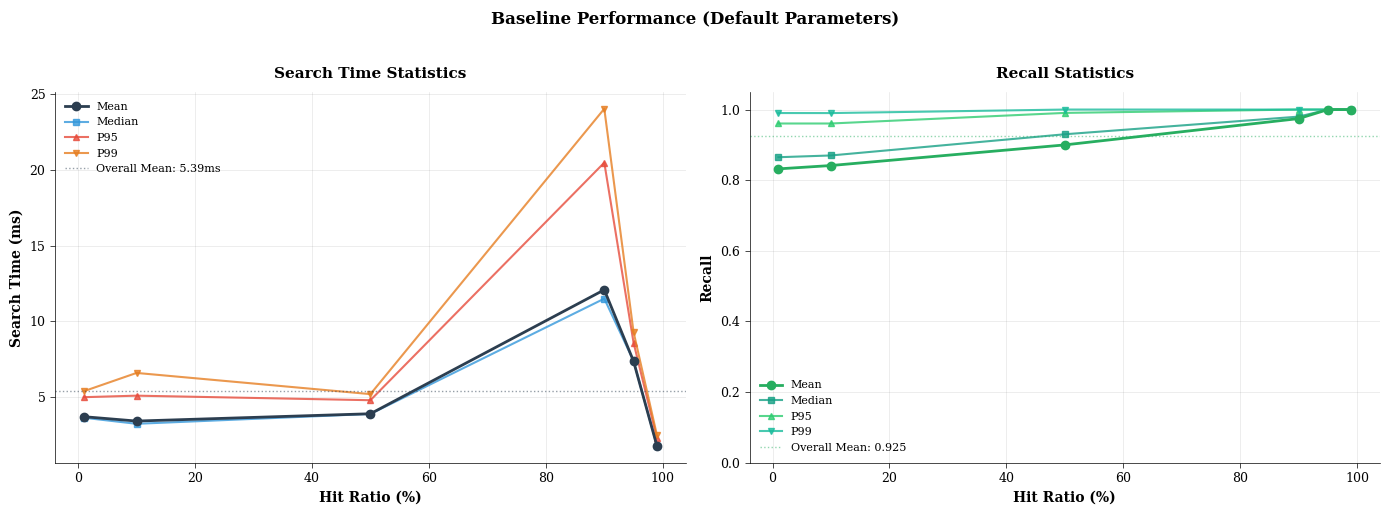

In [25]:
fig = plot_benchmark_results(
    searchtime_before.to_dict(),
    recall_before.to_dict(),
    title="Baseline Performance (Default Parameters)",
)
plt.show()

## Running the Optimizer

Running the optimization is as simple as this:

In [26]:
optimizer = VespaNNParameterOptimizer(
    app=app,
    queries=queries,
    hits=NUMBER_OF_HITS,
    buckets_per_percent=2,
    print_progress=True,
)
report = optimizer.run()

Distributing queries to buckets
  No queries found with filtered-out ratio in [0.25,0.5)
{'buckets_per_percent': 2, 'bucket_interval_width': 0.005, 'non_empty_buckets': [2, 20, 100, 180, 190, 198], 'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99], 'hit_ratios': [0.99, 0.9, 0.5, 0.09999999999999998, 0.050000000000000044, 0.010000000000000009], 'query_distribution': [100, 100, 100, 100, 100, 100]}
Determining suggestion for filterFirstExploration
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.5
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.25
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.125
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.0625
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.03125
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.046875
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.0546875
  Benchmarking: 100.0%
 

Let us inspect the suggested parameters vs the default ones.

In [27]:
def get_suggestions(report):
    suggested_parameters = {}
    for param, value in report.items():
        if "suggestion" in value:
            suggested_parameters[param] = value["suggestion"]
    return suggested_parameters


optimized_params = get_suggestions(report)

print("Suggested vs default parameters:")
for param, value in default_parameters.items():
    print(f"- {param}: {optimized_params[param]:.3f} (default {value:.3f})")

Suggested vs default parameters:
- filterFirstExploration: 0.059 (default 0.300)
- filterFirstThreshold: 0.495 (default 0.300)
- approximateThreshold: 0.010 (default 0.020)
- postFilterThreshold: 0.485 (default 1.000)


## How `VespaNNParameterOptimizer.run()` Works

The `run()` method orchestrates the entire optimization process through a structured sequence of steps. Each step builds upon the results of previous steps to determine optimal parameter values. There is a lot to digest here, so let's break it down a bit:

Below you can see the steps involved when calling the `run()`-method.

### Steps 

**Step 1: Distribute queries to buckets based on filter hit ratios**
   - The optimizer first determines the hit ratio for each query by examining how many documents pass through the filter
   - Queries are then sorted into buckets representing small intervals of hit ratios (controlled by the `buckets_per_percent` parameter)
   - This bucketing allows the optimizer to analyze performance characteristics across the full spectrum of filtering selectivity

**Step 2: Validate query coverage across different hit ratio ranges**
   - The optimizer checks that queries are present across key hit ratio intervals: [0.0-0.25), [0.25-0.50), [0.50-0.75), [0.75-0.90), [0.90-0.95), and [0.95-1.0)
   - It also verifies that non-empty buckets contain a sufficient number of queries (at least 10) to ensure statistical significance
   - If coverage is insufficient, warnings are issued, though optimization continues

**Step 3: Optimize filterFirstExploration** (first parameter)
   - Controls how aggressively the filter-first heuristic explores the HNSW graph when searching for approximate neighbors with filtering
   - Value range: [0.0, 1.0] — higher values improve recall at the cost of response time
   - The optimizer tests multiple exploration values and measures both response time and recall for queries in each bucket
   - Finds the value that best balances response time increase against recall improvement using binary search (typically 7 iterations)
   - Default value is 0.3

**Step 4: Optimize filterFirstThreshold** (second parameter, uses filterFirstExploration from Step 3)
   - Determines when to apply the filter-first heuristic while searching the HNSW graph
   - Value range: [0.0, 1.0] — the heuristic is used when the estimated filter hit ratio is *less than* this threshold
   - Benchmarks two strategies: HNSW-only vs Filter-First (using the optimized exploration value)
   - Identifies the threshold where Filter-First becomes beneficial by comparing response times across buckets
   - Lower hit ratios benefit from checking the filter before computing distances
   - Default value is 0.3 (disabled)

**Step 5: Optimize approximateThreshold** (third parameter, uses filterFirstThreshold and filterFirstExploration from Steps 3-4)
   - Decides when to fall back to exact nearest neighbor search instead of approximate HNSW search
   - Value range: [0.0, 1.0] — exact search is chosen when the estimated filter hit ratio is *less than* this threshold
   - Compares exact search performance against ANN search with the tuned filter-first parameters
   - Identifies buckets where exact search is faster than ANN, working backwards from high selectivity
   - Helps avoid poor performance when filters are highly selective
   - Default value is 0.02

**Step 6: Optimize postFilterThreshold** (fourth parameter, uses all previous parameters)
   - Determines when to use post-filtering instead of the default pre-filtering strategy
   - Value range: [0.0, 1.0] — post-filtering is chosen when the estimated filter hit ratio is *larger than* this threshold
   - Compares post-filtering vs pre-filtering (with all tuned parameters) on both response time and recall
   - Finds the optimal threshold that maximizes response time gain without significant recall loss (less than 1% drop)
   - With post-filtering, targetHits is auto-adjusted to expose enough hits after filtering
   - Default value is 1.0 (disabled)

**Step 7: Return report**
   - Suggested values for all four parameters
   - Benchmark results (response times) for different configurations tested
   - Recall measurements showing quality tradeoffs
   - Query distribution across hit ratio buckets

In [28]:
from IPython.display import display, Markdown
import inspect

run_src = inspect.getsource(VespaNNParameterOptimizer.run)

display(
    Markdown(f"""
<details>
<summary>Click to see the code for the run-method</summary>

```python
{run_src}
```
</details>
""")
)


<details>
<summary>Click to see the code for the run-method</summary>

```python
    def run(self) -> Dict[str, Any]:
        """
        Determines suggestions for all parameters supported by this class.

        This method:
        1. Determines the hit-ratios of supplied ANN queries.
        2. Sorts these queries into buckets based on the determined hit-ratio.
        3. Determines a suggestion for filterFirstExploration.
        4. Determines a suggestion for filterFirstThreshold.
        5. Determines a suggestion for approximateThreshold.
        6. Determines a suggestion for postFilterThreshold.
        7. Reports the determined suggestions and all benchmarks and recall measurements performed.

        Returns:
            dict: A dictionary containing the suggested values, information about the query distribution, performed benchmarks, and recall measurements.

        Example:
            ```python
            {
                "buckets": {
                    "buckets_per_percent": 2,
                    "bucket_interval_width": 0.005,
                    "non_empty_buckets": [
                        2,
                        20,
                        100,
                        180,
                        190,
                        198
                    ],
                    "filtered_out_ratios": [
                        0.01,
                        0.1,
                        0.5,
                        0.9,
                        0.95,
                        0.99
                    ],
                    "hit_ratios": [
                        0.99,
                        0.9,
                        0.5,
                        0.09999999999999998,
                        0.050000000000000044,
                        0.010000000000000009
                    ],
                    "query_distribution": [
                        100,
                        100,
                        100,
                        100,
                        100,
                        100
                    ]
                },
                "filterFirstExploration": {
                    "suggestion": 0.26953125,
                    "benchmarks": {
                        "0.0": [
                            3.739,
                            3.771000000000001,
                            3.4500000000000006,
                            2.838,
                            2.3980000000000015,
                            1.7650000000000008
                        ],
                        "1.0": [
                            3.6299999999999977,
                            3.6859999999999995,
                            3.432000000000002,
                            4.166999999999999,
                            5.185999999999999,
                            7.606999999999999
                        ],
                        "0.5": [
                            3.573,
                            3.543999999999999,
                            3.535000000000001,
                            3.8410000000000006,
                            3.9800000000000004,
                            5.522999999999999
                        ],
                        "0.25": [
                            3.4939999999999998,
                            3.345,
                            3.341,
                            3.011999999999999,
                            2.5979999999999994,
                            2.4250000000000007
                        ],
                        "0.375": [
                            3.5869999999999993,
                            3.4060000000000006,
                            3.252999999999999,
                            3.318,
                            3.2269999999999994,
                            3.7120000000000015
                        ],
                        "0.3125": [
                            3.6000000000000005,
                            3.401,
                            3.2300000000000004,
                            3.089,
                            2.845999999999999,
                            2.986
                        ],
                        "0.28125": [
                            3.5709999999999993,
                            3.606000000000001,
                            3.2519999999999993,
                            3.005,
                            2.728000000000001,
                            2.6400000000000006
                        ],
                        "0.265625": [
                            3.613999999999999,
                            3.381,
                            3.3209999999999997,
                            3.059,
                            2.7200000000000006,
                            2.5120000000000005
                        ],
                        "0.2734375": [
                            3.588999999999998,
                            3.399999999999999,
                            3.3000000000000016,
                            3.017,
                            2.695,
                            2.5850000000000013
                        ]
                    },
                    "recall_measurements": {
                        "0.0": [
                            0.8736999999999999,
                            0.8717999999999994,
                            0.8905000000000004,
                            0.9441999999999999,
                            0.9026000000000005,
                            0.6339999999999995
                        ],
                        "1.0": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9669999999999997,
                            0.9856999999999995,
                            0.9954999999999997
                        ],
                        "0.5": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9656999999999997,
                            0.9764999999999998,
                            0.9904999999999995
                        ],
                        "0.25": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9526999999999994,
                            0.9297999999999998,
                            0.8329
                        ],
                        "0.375": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9611999999999995,
                            0.9592999999999998,
                            0.9623999999999998
                        ],
                        "0.3125": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9573999999999995,
                            0.9425000000000003,
                            0.9082999999999997
                        ],
                        "0.28125": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9555999999999993,
                            0.9365000000000001,
                            0.8779000000000002
                        ],
                        "0.265625": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9542999999999995,
                            0.9322999999999999,
                            0.8537
                        ],
                        "0.2734375": [
                            0.8741999999999999,
                            0.8717999999999994,
                            0.8907000000000005,
                            0.9544999999999995,
                            0.9342,
                            0.8662000000000001
                        ]
                    }
                },
                "filterFirstThreshold": {
                    "suggestion": 0.46,
                    "benchmarks": {
                        "hnsw": [
                            2.818,
                            2.6899999999999995,
                            3.1060000000000008,
                            7.0150000000000015,
                            11.572000000000003,
                            32.068999999999996
                        ],
                        "filter_first": [
                            3.5249999999999995,
                            3.383,
                            3.4959999999999973,
                            3.1700000000000004,
                            2.7319999999999998,
                            2.5430000000000006
                        ]
                    }
                },
                "approximateThreshold": {
                    "suggestion": 0.015,
                    "benchmarks": {
                        "exact": [
                            33.882999999999996,
                            32.803999999999995,
                            24.368000000000002,
                            9.366000000000001,
                            6.071999999999998,
                            2.1279999999999997
                        ],
                        "filter_first": [
                            2.797000000000001,
                            2.638000000000001,
                            3.1540000000000017,
                            2.977,
                            2.745,
                            2.56
                        ]
                    }
                },
                "postFilterThreshold": {
                    "suggestion": 0.49,
                    "benchmarks": {
                        "post_filtering": [
                            1.9979999999999996,
                            2.248,
                            3.0170000000000003,
                            7.204,
                            12.673999999999996,
                            11.397999999999993
                        ],
                        "filter_first": [
                            2.8349999999999995,
                            3.0579999999999994,
                            3.105999999999999,
                            3.375999999999999,
                            2.8720000000000017,
                            2.157999999999999
                        ]
                    },
                    "recall_measurements": {
                        "post_filtering": [
                            0.828,
                            0.8335000000000005,
                            0.8943000000000001,
                            0.9527999999999994,
                            0.9508999999999996,
                            0.1917
                        ],
                        "filter_first": [
                            0.828,
                            0.8359000000000002,
                            0.8980999999999998,
                            0.9543999999999996,
                            0.9338,
                            1.0
                        ]
                    }
                }
            }
            ```
        """
        print("Distributing queries to buckets")
        # Distribute queries to buckets
        self.determine_hit_ratios_and_distribute_to_buckets(self.queries)

        # Check if the queries we have are deemed sufficient
        if not self.has_sufficient_queries():
            print(
                "  Warning: Selection of queries might not cover enough hit ratios to get meaningful results."
            )

        if not self.buckets_sufficiently_filled():
            print("  Warning: Only few queries for a specific hit ratio.")

        bucket_report = {
            "buckets_per_percent": self.buckets_per_percent,
            "bucket_interval_width": self.get_bucket_interval_width(),
            "non_empty_buckets": self.get_non_empty_buckets(),
            "filtered_out_ratios": self.get_filtered_out_ratios(),
            "hit_ratios": list(map(lambda x: 1 - x, self.get_filtered_out_ratios())),
            "query_distribution": self.get_query_distribution()[1],
        }
        if self.print_progress:
            print(bucket_report)

        # Determine filter-first parameters first
        # filterFirstExploration
        if self.print_progress:
            print("Determining suggestion for filterFirstExploration")
        filter_first_exploration_report = self.suggest_filter_first_exploration()
        filter_first_exploration = filter_first_exploration_report["suggestion"]
        if self.print_progress:
            print(filter_first_exploration_report)

        # filterFirstThreshold
        if self.print_progress:
            print("Determining suggestion for filterFirstThreshold")
        filter_first_threshold_report = self.suggest_filter_first_threshold(
            **{"ranking.matching.filterFirstExploration": filter_first_exploration}
        )
        filter_first_threshold = filter_first_threshold_report["suggestion"]
        if self.print_progress:
            print(filter_first_threshold_report)

        # approximateThreshold
        if self.print_progress:
            print("Determining suggestion for approximateThreshold")
        approximate_threshold_report = self.suggest_approximate_threshold(
            **{
                "ranking.matching.filterFirstThreshold": filter_first_threshold,
                "ranking.matching.filterFirstExploration": filter_first_exploration,
            }
        )
        approximate_threshold = approximate_threshold_report["suggestion"]
        if self.print_progress:
            print(approximate_threshold_report)

        # postFilterThreshold
        if self.print_progress:
            print("Determining suggestion for postFilterThreshold")
        post_filter_threshold_report = self.suggest_post_filter_threshold(
            **{
                "ranking.matching.approximateThreshold": approximate_threshold,
                "ranking.matching.filterFirstThreshold": filter_first_threshold,
                "ranking.matching.filterFirstExploration": filter_first_exploration,
            }
        )
        if self.print_progress:
            print(post_filter_threshold_report)

        report = {
            "buckets": bucket_report,
            "filterFirstExploration": filter_first_exploration_report,
            "filterFirstThreshold": filter_first_threshold_report,
            "approximateThreshold": approximate_threshold_report,
            "postFilterThreshold": post_filter_threshold_report,
        }

        return report

```
</details>


If you feel like breaking down the optimization into steps, feel free to run the steps one by one.

## Visualize Optimization Results

Let's vizualize the optimization report to better understand the recommendations.

In [29]:
from typing import Dict, Any, Tuple


def plot_optimization_report(
    report: Dict[str, Any], figsize: Tuple[int, int] = (18, 14)
) -> plt.Figure:
    """
    Create a comprehensive visualization of the VespaNNParameterOptimizer report.

    This function creates a Tufte-inspired multi-panel plot showing parameters in the
    order they are calculated:
    1. filterFirstExploration (response time + recall)
    2. filterFirstThreshold (response time comparison)
    3. approximateThreshold (response time comparison)
    4. postFilterThreshold (response time + recall)

    Args:
        report: The report dictionary generated by VespaNNParameterOptimizer.run()
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Extract data
    buckets = report["buckets"]
    hit_ratios = np.array(buckets["hit_ratios"]) * 100  # Convert to percentage
    query_distribution = buckets["query_distribution"]

    # Create figure with subplots organized by parameter
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        5, 3, hspace=0.5, wspace=0.3, top=0.94, bottom=0.05, left=0.06, right=0.97
    )

    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Row 0: Query Distribution + Summary Table
    # 1. Query Distribution (top left, spans 2 columns)
    ax_dist = fig.add_subplot(gs[0, 0:2])

    # Use evenly spaced x-positions for bars
    x_positions = np.arange(len(hit_ratios))
    _bars = ax_dist.bar(
        x_positions,
        query_distribution,
        width=0.7,
        color="#4A90E2",
        alpha=0.7,
        edgecolor="#2E5C8A",
        linewidth=0.5,
    )

    ax_dist.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_dist.set_ylabel("Number of Queries", fontsize=10, fontweight="bold")
    ax_dist.set_title(
        "Query Distribution Across Hit Ratios", fontsize=11, fontweight="bold", pad=10
    )
    ax_dist.set_xticks(x_positions)
    ax_dist.set_xticklabels([f"{hr:.1f}" for hr in hit_ratios], rotation=0)
    setup_tufte_axes(ax_dist)

    # Add value labels on bars
    for i, (x_pos, height) in enumerate(zip(x_positions, query_distribution)):
        ax_dist.text(
            x_pos, height, f"{int(height)}", ha="center", va="bottom", fontsize=8
        )

    # 2. Summary Table (top right)
    ax_summary = fig.add_subplot(gs[0, 2])
    ax_summary.axis("off")

    summary_data = [
        ["Parameter", "Suggested"],
        ["", ""],
        [
            "filterFirstExploration",
            f"{report['filterFirstExploration']['suggestion']:.4f}",
        ],
        ["filterFirstThreshold", f"{report['filterFirstThreshold']['suggestion']:.4f}"],
        ["approximateThreshold", f"{report['approximateThreshold']['suggestion']:.4f}"],
        ["postFilterThreshold", f"{report['postFilterThreshold']['suggestion']:.4f}"],
        ["", ""],
        ["Total Queries", f"{sum(query_distribution)}"],
        ["Number of buckets", f"{len(buckets)}"],
        ["Buckets per %", f"{buckets['buckets_per_percent']}"],
    ]

    table = ax_summary.table(
        cellText=summary_data,
        cellLoc="left",
        loc="center",
        colWidths=[0.65, 0.35],
        bbox=[0, 0, 1, 1],
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # Style the table
    for i, row in enumerate(summary_data):
        for j in range(len(row)):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor("#34495E")
                cell.set_text_props(weight="bold", color="white", size=8)
            elif i == 1 or i == 6:  # Separator rows
                cell.set_facecolor("#ECF0F1")
                cell.set_height(0.02)
            elif i >= 7:  # Info section
                cell.set_facecolor("#F8F9FA")
            else:
                cell.set_facecolor("white")
            cell.set_edgecolor("#BDC3C7")
            cell.set_linewidth(0.5)

    ax_summary.set_title("Summary", fontsize=11, fontweight="bold", pad=10, loc="left")

    # Row 1: filterFirstExploration (calculated first)
    # Response Time
    ax_ffe_rt = fig.add_subplot(gs[1, 0:2])
    ffe_data = report["filterFirstExploration"]
    ffe_suggestion = ffe_data["suggestion"]

    exploration_values = sorted([k for k in ffe_data["benchmarks"].keys()])
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(exploration_values)))

    for i, exp_val in enumerate(exploration_values):
        benchmarks = ffe_data["benchmarks"][exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_rt.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_title(
        f"1. filterFirstExploration: {ffe_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_ffe_rt.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_rt)

    # Recall
    ax_ffe_recall = fig.add_subplot(gs[1, 2])
    recall_measurements = ffe_data["recall_measurements"]

    for i, exp_val in enumerate(exploration_values):
        recalls = recall_measurements[exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_recall.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_ffe_recall.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_recall)

    # Row 2: filterFirstThreshold (calculated second)
    ax_fft = fig.add_subplot(gs[2, :])
    fft_data = report["filterFirstThreshold"]
    fft_suggestion = fft_data["suggestion"]

    benchmarks_hnsw = fft_data["benchmarks"]["hnsw"]
    benchmarks_ff = fft_data["benchmarks"]["filter_first"]

    ax_fft.plot(
        hit_ratios,
        benchmarks_hnsw,
        "o-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="HNSW only",
        alpha=0.8,
    )
    ax_fft.plot(
        hit_ratios,
        benchmarks_ff,
        "s-",
        color="#27AE60",
        linewidth=1.5,
        markersize=5,
        label="Filter-First",
        alpha=0.8,
    )

    # Add suggestion line
    ax_fft.axvline(
        x=fft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {fft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_fft.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_fft.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_fft.set_title(
        f"2. filterFirstThreshold: {fft_suggestion:.4f}",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_fft.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_fft)

    # Row 3: approximateThreshold (calculated third) - full row
    ax_at = fig.add_subplot(gs[3, :])
    at_data = report["approximateThreshold"]
    at_suggestion = at_data["suggestion"]

    benchmarks_exact = at_data["benchmarks"]["exact"]
    benchmarks_ann = at_data["benchmarks"]["filter_first"]

    ax_at.plot(
        hit_ratios,
        benchmarks_exact,
        "o-",
        color="#9B59B6",
        linewidth=1.5,
        markersize=5,
        label="Exact search",
        alpha=0.8,
    )
    ax_at.plot(
        hit_ratios,
        benchmarks_ann,
        "s-",
        color="#F39C12",
        linewidth=1.5,
        markersize=5,
        label="ANN (tuned)",
        alpha=0.8,
    )

    # Add suggestion line
    ax_at.axvline(
        x=at_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {at_suggestion:.3f}",
        alpha=0.7,
    )

    ax_at.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_at.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_at.set_title(
        f"3. approximateThreshold: {at_suggestion:.4f}",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_at.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_at)

    # Row 4: postFilterThreshold (calculated fourth) - Response Time + Recall
    ax_pft_rt = fig.add_subplot(gs[4, 0:2])
    pft_data = report["postFilterThreshold"]
    pft_suggestion = pft_data["suggestion"]

    benchmarks_post = pft_data["benchmarks"]["post_filtering"]
    benchmarks_pre = pft_data["benchmarks"]["filter_first"]

    # Response time comparison
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )
    ax_pft_rt.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_rt.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_pft_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_pft_rt.set_title(
        f"4. postFilterThreshold: {pft_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_pft_rt.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_rt)

    # Recall comparison
    ax_pft_recall = fig.add_subplot(gs[4, 2])
    recall_post = pft_data["recall_measurements"]["post_filtering"]
    recall_pre = pft_data["recall_measurements"]["filter_first"]

    ax_pft_recall.plot(
        hit_ratios,
        recall_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_recall.plot(
        hit_ratios,
        recall_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )

    # Add suggestion line
    ax_pft_recall.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_recall.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_pft_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_pft_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_pft_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_recall)

    # Overall title
    fig.suptitle(
        "Vespa NN Parameter Optimization Report (Calculation Order)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    return fig

In [30]:
from IPython.display import display, Markdown
import inspect

plot_src = inspect.getsource(plot_optimization_report)

display(
    Markdown(f"""
<details>
<summary>Click to see the plotting code</summary>

```python
{plot_src}
```
</details>
""")
)


<details>
<summary>Click to see the plotting code</summary>

```python
def plot_optimization_report(
    report: Dict[str, Any], figsize: Tuple[int, int] = (18, 14)
) -> plt.Figure:
    """
    Create a comprehensive visualization of the VespaNNParameterOptimizer report.

    This function creates a Tufte-inspired multi-panel plot showing parameters in the
    order they are calculated:
    1. filterFirstExploration (response time + recall)
    2. filterFirstThreshold (response time comparison)
    3. approximateThreshold (response time comparison)
    4. postFilterThreshold (response time + recall)

    Args:
        report: The report dictionary generated by VespaNNParameterOptimizer.run()
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Extract data
    buckets = report["buckets"]
    hit_ratios = np.array(buckets["hit_ratios"]) * 100  # Convert to percentage
    query_distribution = buckets["query_distribution"]

    # Create figure with subplots organized by parameter
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        5, 3, hspace=0.5, wspace=0.3, top=0.94, bottom=0.05, left=0.06, right=0.97
    )

    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Row 0: Query Distribution + Summary Table
    # 1. Query Distribution (top left, spans 2 columns)
    ax_dist = fig.add_subplot(gs[0, 0:2])

    # Use evenly spaced x-positions for bars
    x_positions = np.arange(len(hit_ratios))
    _bars = ax_dist.bar(
        x_positions,
        query_distribution,
        width=0.7,
        color="#4A90E2",
        alpha=0.7,
        edgecolor="#2E5C8A",
        linewidth=0.5,
    )

    ax_dist.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_dist.set_ylabel("Number of Queries", fontsize=10, fontweight="bold")
    ax_dist.set_title(
        "Query Distribution Across Hit Ratios", fontsize=11, fontweight="bold", pad=10
    )
    ax_dist.set_xticks(x_positions)
    ax_dist.set_xticklabels([f"{hr:.1f}" for hr in hit_ratios], rotation=0)
    setup_tufte_axes(ax_dist)

    # Add value labels on bars
    for i, (x_pos, height) in enumerate(zip(x_positions, query_distribution)):
        ax_dist.text(
            x_pos, height, f"{int(height)}", ha="center", va="bottom", fontsize=8
        )

    # 2. Summary Table (top right)
    ax_summary = fig.add_subplot(gs[0, 2])
    ax_summary.axis("off")

    summary_data = [
        ["Parameter", "Suggested"],
        ["", ""],
        [
            "filterFirstExploration",
            f"{report['filterFirstExploration']['suggestion']:.4f}",
        ],
        ["filterFirstThreshold", f"{report['filterFirstThreshold']['suggestion']:.4f}"],
        ["approximateThreshold", f"{report['approximateThreshold']['suggestion']:.4f}"],
        ["postFilterThreshold", f"{report['postFilterThreshold']['suggestion']:.4f}"],
        ["", ""],
        ["Total Queries", f"{sum(query_distribution)}"],
        ["Number of buckets", f"{len(buckets)}"],
        ["Buckets per %", f"{buckets['buckets_per_percent']}"],
    ]

    table = ax_summary.table(
        cellText=summary_data,
        cellLoc="left",
        loc="center",
        colWidths=[0.65, 0.35],
        bbox=[0, 0, 1, 1],
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # Style the table
    for i, row in enumerate(summary_data):
        for j in range(len(row)):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor("#34495E")
                cell.set_text_props(weight="bold", color="white", size=8)
            elif i == 1 or i == 6:  # Separator rows
                cell.set_facecolor("#ECF0F1")
                cell.set_height(0.02)
            elif i >= 7:  # Info section
                cell.set_facecolor("#F8F9FA")
            else:
                cell.set_facecolor("white")
            cell.set_edgecolor("#BDC3C7")
            cell.set_linewidth(0.5)

    ax_summary.set_title("Summary", fontsize=11, fontweight="bold", pad=10, loc="left")

    # Row 1: filterFirstExploration (calculated first)
    # Response Time
    ax_ffe_rt = fig.add_subplot(gs[1, 0:2])
    ffe_data = report["filterFirstExploration"]
    ffe_suggestion = ffe_data["suggestion"]

    exploration_values = sorted([k for k in ffe_data["benchmarks"].keys()])
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(exploration_values)))

    for i, exp_val in enumerate(exploration_values):
        benchmarks = ffe_data["benchmarks"][exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_rt.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_title(
        f"1. filterFirstExploration: {ffe_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_ffe_rt.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_rt)

    # Recall
    ax_ffe_recall = fig.add_subplot(gs[1, 2])
    recall_measurements = ffe_data["recall_measurements"]

    for i, exp_val in enumerate(exploration_values):
        recalls = recall_measurements[exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_recall.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_ffe_recall.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_recall)

    # Row 2: filterFirstThreshold (calculated second)
    ax_fft = fig.add_subplot(gs[2, :])
    fft_data = report["filterFirstThreshold"]
    fft_suggestion = fft_data["suggestion"]

    benchmarks_hnsw = fft_data["benchmarks"]["hnsw"]
    benchmarks_ff = fft_data["benchmarks"]["filter_first"]

    ax_fft.plot(
        hit_ratios,
        benchmarks_hnsw,
        "o-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="HNSW only",
        alpha=0.8,
    )
    ax_fft.plot(
        hit_ratios,
        benchmarks_ff,
        "s-",
        color="#27AE60",
        linewidth=1.5,
        markersize=5,
        label="Filter-First",
        alpha=0.8,
    )

    # Add suggestion line
    ax_fft.axvline(
        x=fft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {fft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_fft.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_fft.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_fft.set_title(
        f"2. filterFirstThreshold: {fft_suggestion:.4f}",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_fft.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_fft)

    # Row 3: approximateThreshold (calculated third) - full row
    ax_at = fig.add_subplot(gs[3, :])
    at_data = report["approximateThreshold"]
    at_suggestion = at_data["suggestion"]

    benchmarks_exact = at_data["benchmarks"]["exact"]
    benchmarks_ann = at_data["benchmarks"]["filter_first"]

    ax_at.plot(
        hit_ratios,
        benchmarks_exact,
        "o-",
        color="#9B59B6",
        linewidth=1.5,
        markersize=5,
        label="Exact search",
        alpha=0.8,
    )
    ax_at.plot(
        hit_ratios,
        benchmarks_ann,
        "s-",
        color="#F39C12",
        linewidth=1.5,
        markersize=5,
        label="ANN (tuned)",
        alpha=0.8,
    )

    # Add suggestion line
    ax_at.axvline(
        x=at_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {at_suggestion:.3f}",
        alpha=0.7,
    )

    ax_at.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_at.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_at.set_title(
        f"3. approximateThreshold: {at_suggestion:.4f}",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_at.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_at)

    # Row 4: postFilterThreshold (calculated fourth) - Response Time + Recall
    ax_pft_rt = fig.add_subplot(gs[4, 0:2])
    pft_data = report["postFilterThreshold"]
    pft_suggestion = pft_data["suggestion"]

    benchmarks_post = pft_data["benchmarks"]["post_filtering"]
    benchmarks_pre = pft_data["benchmarks"]["filter_first"]

    # Response time comparison
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )
    ax_pft_rt.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_rt.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_pft_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_pft_rt.set_title(
        f"4. postFilterThreshold: {pft_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_pft_rt.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_rt)

    # Recall comparison
    ax_pft_recall = fig.add_subplot(gs[4, 2])
    recall_post = pft_data["recall_measurements"]["post_filtering"]
    recall_pre = pft_data["recall_measurements"]["filter_first"]

    ax_pft_recall.plot(
        hit_ratios,
        recall_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_recall.plot(
        hit_ratios,
        recall_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )

    # Add suggestion line
    ax_pft_recall.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_recall.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_pft_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_pft_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_pft_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_recall)

    # Overall title
    fig.suptitle(
        "Vespa NN Parameter Optimization Report (Calculation Order)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    return fig

```
</details>


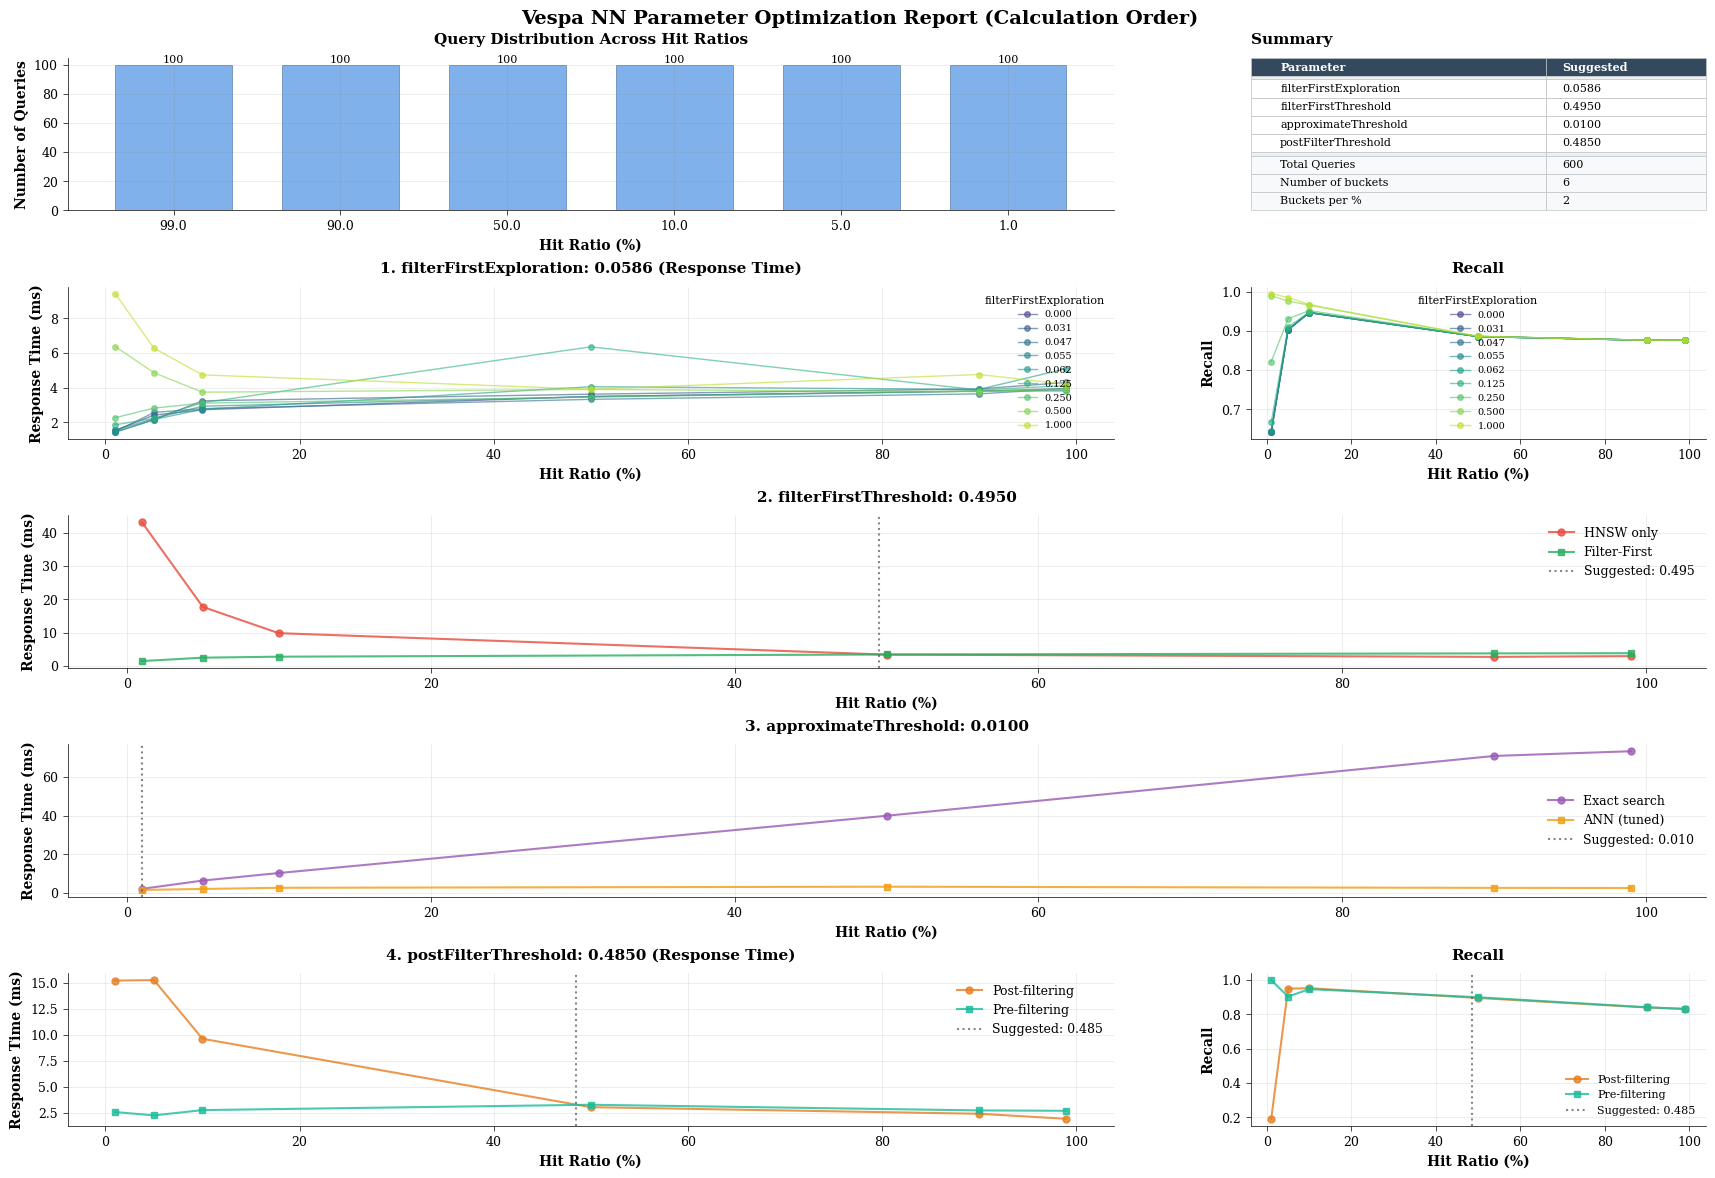

In [31]:
# Generate the visualization
fig = plot_optimization_report(report, figsize=(18, 12))
plt.show()

## Check if we improved



In [32]:
searchtime_after, recall_after = run_benchmark(app, optimized_params)

Step 1: Distributing queries to buckets based on hit ratios...
  Benchmarking: 100.0%
  Computing recall: 100.0%


In [35]:
searchtime_after.to_dict(), searchtime_before.to_dict()

({'metric_name': 'searchtime',
  'buckets': [2, 20, 100, 180, 190, 198],
  'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99],
  'statistics': {'mean': [2.7100000000000004,
    2.6769999999999987,
    3.2939999999999987,
    9.435999999999998,
    6.842,
    2.292],
   'median': [2.7, 2.6, 3.3, 9.5, 6.7, 2.2],
   'p95': [3.309999999999999,
    3.4099999999999993,
    4.1,
    11.604999999999999,
    8.0,
    2.914999999999999],
   'p99': [3.8030000000000013,
    4.001,
    4.301,
    12.701,
    8.807000000000004,
    5.704000000000002]},
  'summary': {'overall_mean': 4.541833333333333, 'overall_median': 3.002}},
 {'metric_name': 'searchtime',
  'buckets': [2, 20, 100, 180, 190, 198],
  'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99],
  'statistics': {'mean': [3.719,
    3.431000000000001,
    3.913000000000001,
    12.081999999999995,
    7.38,
    1.7959999999999996],
   'median': [3.6500000000000004, 3.25, 3.9, 11.5, 7.4, 1.8],
   'p95': [5.005,
    5.1049999999999995

In [41]:
recall_before.to_dict(), recall_after.to_dict()

({'metric_name': 'recall',
  'buckets': [2, 20, 100, 180, 190, 198],
  'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99],
  'statistics': {'mean': [0.8320000000000001,
    0.8414999999999996,
    0.8998999999999997,
    0.9743999999999998,
    1.0,
    1.0],
   'median': [0.865, 0.87, 0.93, 0.98, 1.0, 1.0],
   'p95': [0.9604999999999999,
    0.9604999999999999,
    0.9904999999999999,
    1.0,
    1.0,
    1.0],
   'p99': [0.9901000000000001, 0.99, 1.0, 1.0, 1.0, 1.0]},
  'summary': {'overall_mean': 0.9246333333333331,
   'overall_median': 0.9371499999999997}},
 {'metric_name': 'recall',
  'buckets': [2, 20, 100, 180, 190, 198],
  'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99],
  'statistics': {'mean': [0.8320000000000001,
    0.8414999999999996,
    0.8998999999999997,
    0.9743999999999998,
    1.0,
    1.0],
   'median': [0.865, 0.87, 0.93, 0.98, 1.0, 1.0],
   'p95': [0.9604999999999999,
    0.9604999999999999,
    0.9904999999999999,
    1.0,
    1.0,
    1.0],
  

In [ ]:
import pandas as pd
from typing import Tuple


def calculate_metric_diff(
    after_dict: dict, before_dict: dict
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate differences between after and before metrics (searchtime or recall).

    Works for both searchtime (where lower is better) and recall (where higher is better).

    Args:
        after_dict: Dictionary containing metrics after optimization
        before_dict: Dictionary containing metrics before optimization

    Returns:
        Tuple of (df_stats, df_summary) DataFrames with absolute differences and percentage changes
    """
    # Extract hit ratios (same for both)
    hit_ratios = after_dict["filtered_out_ratios"]
    metric_name = after_dict.get("metric_name", "metric")

    # Create DataFrame for statistics
    stats_data = []
    for stat_name in ["mean", "median", "p95", "p99"]:
        after_values = np.array(after_dict["statistics"][stat_name])
        before_values = np.array(before_dict["statistics"][stat_name])

        abs_diff = after_values - before_values
        pct_change = ((after_values - before_values) / before_values) * 100

        for i, hr in enumerate(hit_ratios):
            stats_data.append(
                {
                    "hit_ratio": hr,
                    "statistic": stat_name,
                    "before": before_values[i],
                    "after": after_values[i],
                    "abs_diff": abs_diff[i],
                    "pct_change": pct_change[i],
                }
            )

    df_stats = pd.DataFrame(stats_data)

    # Create DataFrame for summary statistics
    summary_data = []
    for metric in ["overall_mean", "overall_median"]:
        before_val = before_dict["summary"][metric]
        after_val = after_dict["summary"][metric]
        abs_diff = after_val - before_val
        pct_change = ((after_val - before_val) / before_val) * 100

        summary_data.append(
            {
                "metric": metric,
                "before": before_val,
                "after": after_val,
                "abs_diff": abs_diff,
                "pct_change": pct_change,
            }
        )

    df_summary = pd.DataFrame(summary_data)

    # Add metric name to both dataframes for clarity
    df_stats["metric_name"] = metric_name
    df_summary["metric_name"] = metric_name

    return df_stats, df_summary


# Calculate differences for searchtime
searchtime_stats, searchtime_summary = calculate_metric_diff(
    searchtime_after.to_dict(), searchtime_before.to_dict()
)

# Calculate differences for recall
recall_stats, recall_summary = calculate_metric_diff(
    recall_after.to_dict(), recall_before.to_dict()
)
searchtime_stats

,hit_ratio,statistic,before,after,abs_diff,pct_change,metric_name
0,0.01,mean,3.719,2.710,-1.009,-27.130949,searchtime
1,0.10,mean,3.431,2.677,-0.754,-21.976100,searchtime
2,0.50,mean,3.913,3.294,-0.619,-15.819065,searchtime
3,0.90,mean,12.082,9.436,-2.646,-21.900348,searchtime
4,0.95,mean,7.380,6.842,-0.538,-7.289973,searchtime
5,0.99,mean,1.796,2.292,0.496,27.616927,searchtime
6,0.01,median,3.650,2.700,-0.950,-26.027397,searchtime
7,0.10,median,3.250,2.600,-0.650,-20.000000,searchtime
8,0.50,median,3.900,3.300,-0.600,-15.384615,searchtime
9,0.90,median,11.500,9.500,-2.000,-17.391304,searchtime


We can see that the mean searchtime across the queries did not change that much, and actually got a bit worse for hitratio 0.99. 

The real benefit comes from reducing the tail latencies of "problematic" queries, which have hit ratios right in the area where choosing a better ANN-strategy matters a lot. 

This can be seen for hitratio `0.90`, where tuning the parameters resulted in a p95 latency drop of 43% (from 20.465 to 11.605 ms), and the p99 latency even more.

And this provide an important lesson: 

Tuning the parameters that determine the ANN-strategy is not likely to reduce the mean of your latencies, but to reduce the latency of the most problematic queries. 

Therefore, it may be wise to log and add these high latency queries to a query set in order to improve them. 

But don't forget to include a representative sample of your other queries as well, to make sure that you don't just switch strategy at the cost of other queries.

Now, let us take a look at the recall stats:

In [43]:
recall_stats

,hit_ratio,statistic,before,after,abs_diff,pct_change,metric_name
0,0.01,mean,0.8320,0.8320,0.0,0.0,recall
1,0.10,mean,0.8415,0.8415,0.0,0.0,recall
2,0.50,mean,0.8999,0.8999,0.0,0.0,recall
3,0.90,mean,0.9744,0.9744,0.0,0.0,recall
4,0.95,mean,1.0000,1.0000,0.0,0.0,recall
5,0.99,mean,1.0000,1.0000,0.0,0.0,recall
6,0.01,median,0.8650,0.8650,0.0,0.0,recall
7,0.10,median,0.8700,0.8700,0.0,0.0,recall
8,0.50,median,0.9300,0.9300,0.0,0.0,recall
9,0.90,median,0.9800,0.9800,0.0,0.0,recall


We can see that the recall remains unchanged across all hit ratios. 

This is expected, as the tuning code only accepts a recall decrease of 1%. 

If you are willing to trade even less recall for faster searchtimes, you could reduce the [targetHits](https://docs.vespa.ai/en/nearest-neighbor-search.html#querying-using-nearestneighbor-query-operator)-parameter passed to the [nearestNeighbor](https://docs.vespa.ai/en/reference/query-language-reference.html#nearestneighbor)-query operator. (Or increase it if you want more recall at the cost of higher latencies).

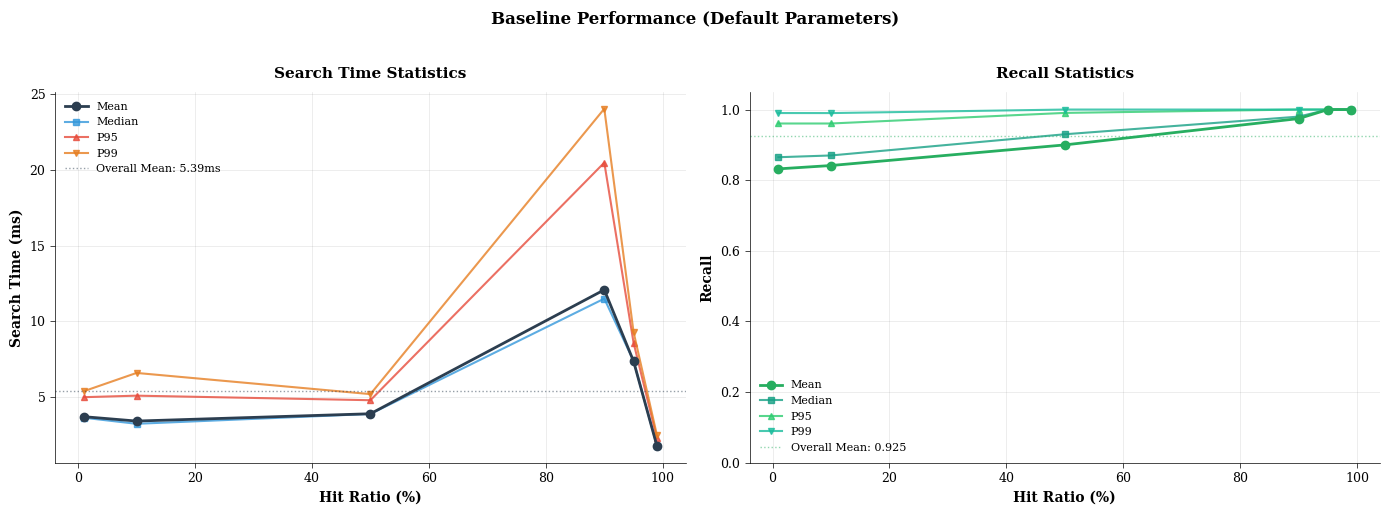

In [40]:
fig = plot_benchmark_results(
    searchtime_before.to_dict(),
    recall_before.to_dict(),
    title="Baseline Performance (Default Parameters)",
)
plt.show()

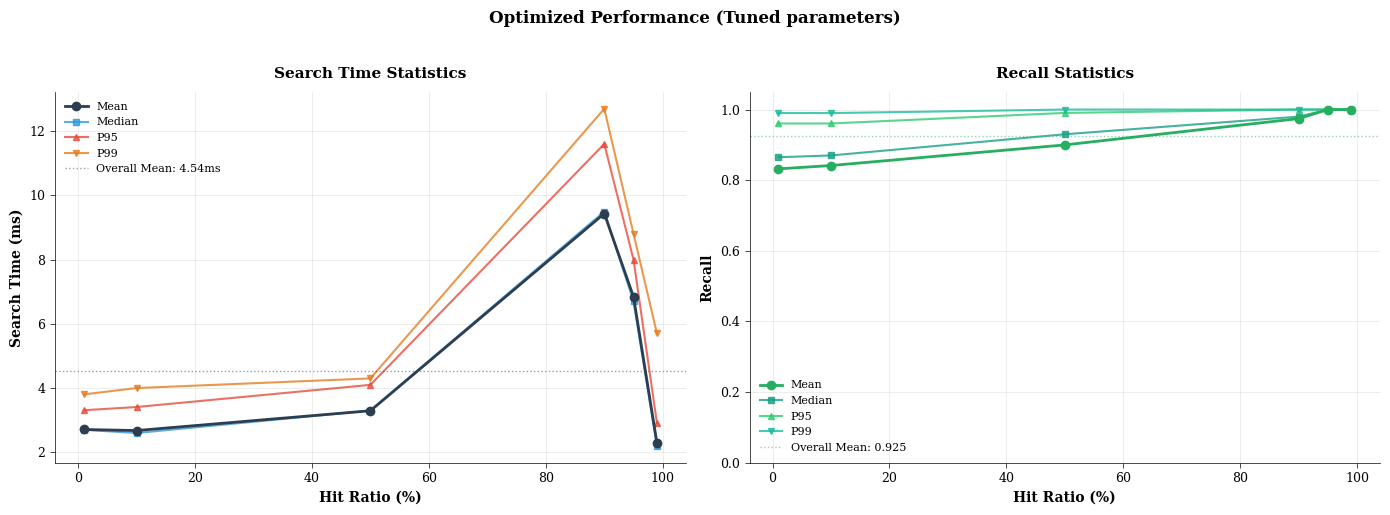

In [33]:
fig = plot_benchmark_results(
    searchtime_after.to_dict(),
    recall_after.to_dict(),
    title="Optimized Performance (Tuned parameters)",
)
plt.show()

## Conclusion and next steps

Now that you have tuned your ANN-parameters for recall and performance, consider doing quality evaluation. 

Take a look at the [Evaluating a Vespa application](https://vespa-engine.github.io/pyvespa/evaluating-vespa-application-cloud.html)-notebook for some tips on getting started. 

## FAQ

**Q: When should I consider re-tuning the ANN-parameters?**

If either your corpus or your query load changes so that the typical hit ratios for your queries change.

**Q: Will this tuning guarantee low latency across all queries?**

No, but if you observe queries with high-latency, consider adding these queries to your tuning queries, and rerun the optimization to ensure these queries are accounted for. 

**Q: What if I observe poor recall for some ANN queries?** 

Consider increasing your `filterfirstExploration` value. Note that this comes at a cost of latency. 

### Delete application

The following will delete the application and data from the dev environment.

In [34]:
if os.getenv("CI") == "true":
    vespa_cloud.delete()